In [1]:
import sys
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Using TensorFlow backend.


In [2]:
#import kapre
import keras
import keras.utils as ku

from keras.layers import Conv2D, LocallyConnected2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, PReLU, Input, add, Layer
from keras.layers import BatchNormalization, UpSampling2D, Activation, Dropout, MaxPooling2D, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard
from keras.models import Sequential, load_model, Model
from keras.utils import to_categorical, plot_model
from keras.metrics import mean_squared_error
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import RandomNormal
import keras.backend as K

In [3]:
class RReLU(Layer):
    '''Randomized Leaky Rectified Linear Unit
    that uses a random alpha in training while using the average of alphas
    in testing phase:
    During training
    `f(x) = alpha * x for x < 0, where alpha ~ U(l, u), l < u`,
    `f(x) = x for x >= 0`.
    During testing:
    `f(x) = (l + u) / 2 * x for x < 0`,
    `f(x) = x for x >= 0`.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as the input.
    # Arguments
        l: lower bound of the uniform distribution, default is 1/8
        u: upper bound of the uniform distribution, default is 1/3
    # References
        - [Empirical Evaluation of Rectified Activations in Convolution Network](https://arxiv.org/pdf/1505.00853v2.pdf)
    '''

    def __init__(self, l=1/10., u=1/9., **kwargs):
        self.supports_masking = True
        self.l = l
        self.u = u
        self.average = (l + u) / 2
        self.uses_learning_phase = True
        super(RReLU, self).__init__(**kwargs)

    def call(self, x, mask=None):
        return K.in_train_phase(K.relu(x, np.random.uniform(self.l, self.u)),
                                K.relu(x, self.average))
    
    def build(self, input_shape):
        super(RReLU, self).build(input_shape)


    def get_config(self):
        config = {'l': self.l, 'u': self.u}
        base_config = super(RReLU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    # def compute_output_shape(self, input_shape):
    #     return input_shape

In [5]:
saved_modelt = load_model('C:\\Users\\noemi\\Desktop\\university\\university\\tesi\\Thesis-XAI\\resources\\best_models\\best_modelinc0.h5',custom_objects={'RReLU': RReLU})
saved_modelt.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Model: "Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 10, 512, 1)   0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 10, 128, 32)  448         input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 10, 128, 32)  40          conv2d_136[0][0]                 
__________________________________________________________________________________________________
r_re_lu_163 (RReLU)             (None, 10, 128, 32)  0           batch_normalization_163[0][0]    
_________

## IMPORT DATA

In [6]:
dataset = np.load('../resources/data/final_dataset-004.npy', allow_pickle=True)
label = np.load('../resources/data/final_label.npy', allow_pickle=True)
move = np.load('../resources/data/final_move.npy', allow_pickle=True)

print('Data base Shape', np.shape(dataset))
print('subject 1 database shape', dataset[0][0].shape)

print('lable Shape', np.shape(label))
print('subject 1 lable shape', label[0][0].shape)

print('move Shape', np.shape(move))
print('subject 1 move shape', move[0][0].shape)

Data base Shape (11, 3)
subject 1 database shape (2887, 10, 512)
lable Shape (11, 3)
subject 1 lable shape (2887,)
move Shape (11, 3)
subject 1 move shape (2887,)


In [7]:
xtrain_r=[]
xtest_r=[]
ytrain_r=[]
ytest_r=[]


Xtrainset = []
Xtestset = []
Ytrainset = []
Ytestset = []

for subject in range(11):
    xtrain_rr=[]
    xtest_rr=[]
    ytrain_rr=[]
    ytest_rr=[]
    for r in range(3):
        xtrain_rrr=np.array([[[0]*512]*10])
        xtest_rrr=np.array([[[0]*512]*10])
        ytrain_rrr=np.array([0])
        ytest_rrr=np.array([0])

        tempset = dataset[subject][r]
        tempmove = move[subject][r]
        templabel = label[subject][r]
        for clas in range(1,9):
            movenum = np.unique(tempmove[templabel==clas])
            trainsize = int((2/3) * len(movenum))
            for i in range(trainsize):
                xtrain_rrr = np.append(xtrain_rrr,tempset[tempmove==movenum[i]],axis=0) 
                ytrain_rrr = np.append(ytrain_rrr,templabel[tempmove==movenum[i]],axis=0)
            for i in range(trainsize,len(movenum)):
                xtest_rrr = np.append(xtest_rrr,tempset[tempmove==movenum[i]],axis=0) 
                ytest_rrr = np.append(ytest_rrr,templabel[tempmove==movenum[i]],axis=0)
      
        xtrain_rr.append(xtrain_rrr[1:])
        xtest_rr.append(xtest_rrr[1:])
        ytrain_rr.append(ytrain_rrr[1:])
        ytest_rr.append(ytest_rrr[1:])
    xtrain_r.append(xtrain_rr)
    xtest_r.append(xtest_rr)
    ytrain_r.append(ytrain_rr)
    ytest_r.append(ytest_rr)

    Xtrainset.append(np.append(np.append(xtrain_rr[0],xtrain_rr[1],axis=0),xtrain_rr[2],axis=0))
    Xtestset.append(np.append(np.append(xtest_rr[0],xtest_rr[1],axis=0),xtest_rr[2],axis=0))
    Ytrainset.append(np.append(np.append(ytrain_rr[0],ytrain_rr[1],axis=0),ytrain_rr[2],axis=0))
    Ytestset.append(np.append(np.append(ytest_rr[0],ytest_rr[1],axis=0),ytest_rr[2],axis=0))

print("full train roundi database shape : " + str(np.shape(xtrain_r)))
print("full test roundi  label shape : " + str(np.shape(xtest_r)))

print("full train database shape : " + str(np.shape(Xtrainset)))
print("full test label shape : " + str(np.shape(Xtestset)))

print(" train subject 1 round 1 database shape : " + str(xtrain_r[0][0].shape))
print("test subject 1 round 1 database shape : " + str(xtest_r[0][0].shape))

print(" train subject 1 round 2 database shape : " + str(xtrain_r[0][1].shape))
print("test subject 1 round 2 database shape : " + str(xtest_r[0][1].shape))

print(" train subject 1 round 3 database shape : " + str(xtrain_r[0][2].shape))
print("test subject 1 round 3 database shape : " + str(xtest_r[0][2].shape))

print(" train subject 1 database shape : " + str(Xtrainset[0].shape))
print("test subject 1 database shape : " + str(Xtestset[0].shape))


full train roundi database shape : (11, 3)
full test roundi  label shape : (11, 3)
full train database shape : (11,)
full test label shape : (11,)
 train subject 1 round 1 database shape : (1732, 10, 512)
test subject 1 round 1 database shape : (1155, 10, 512)
 train subject 1 round 2 database shape : (1657, 10, 512)
test subject 1 round 2 database shape : (1118, 10, 512)
 train subject 1 round 3 database shape : (1474, 10, 512)
test subject 1 round 3 database shape : (1024, 10, 512)
 train subject 1 database shape : (4863, 10, 512)
test subject 1 database shape : (3297, 10, 512)


In [8]:
from sklearn.utils import shuffle
for i in range(11):
    Xtrainset[i] , Ytrainset[i] = shuffle(Xtrainset[i],Ytrainset[i])
    Xtestset[i] , Ytestset[i] = shuffle(Xtestset[i],Ytestset[i])
  # Xtrainset[i] = np.swapaxes(Xtrainset[i],1,2)
  # Xtestset[i] = np.swapaxes(Xtestset[i],1,2)
    print("full test label shape : " + str(Xtestset[i].shape))
for i in range (11):
    Xtrainset[i] = Xtrainset[i].reshape(Xtrainset[i].shape[0],Xtrainset[i].shape[1],Xtrainset[i].shape[2],1)
    Xtestset[i] = Xtestset[i].reshape(Xtestset[i].shape[0],Xtestset[i].shape[1],Xtestset[i].shape[2],1)
print("full test label shape : " + str(Xtestset[0].shape))

full test label shape : (3297, 10, 512)
full test label shape : (3301, 10, 512)
full test label shape : (3280, 10, 512)
full test label shape : (3073, 10, 512)
full test label shape : (3324, 10, 512)
full test label shape : (3308, 10, 512)
full test label shape : (3273, 10, 512)
full test label shape : (3041, 10, 512)
full test label shape : (3174, 10, 512)
full test label shape : (3294, 10, 512)
full test label shape : (3254, 10, 512)
full test label shape : (3297, 10, 512, 1)


In [9]:
Xtest=Xtestset[0]
ytest=Ytestset[0]
print(ytest[:10])
ytest=to_categorical(ytest-1,8)
print(ytest[:10,:])
# evaluate the model
scores = saved_modelt.evaluate(Xtest, ytest, verbose=0)
# a = saved_model.evaluate(self.xtest[1], to_categorical(self.ytest[1]-1,8), verbose=0)
print("Result on test set for taregt domain: %s: %.2f%%" % (saved_modelt.metrics_names[1], scores[1] * 100))
preds=saved_modelt.predict(Xtest)


[8. 4. 5. 6. 1. 1. 3. 8. 3. 3.]
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]
Result on test set for taregt domain: accuracy: 93.66%


In [10]:
Xtest[0,:,:,0].shape

(10, 512)

In [11]:
x=np.expand_dims(Xtest[8], axis=0)


In [12]:
print(to_categorical((np.argmax((preds), axis=1)),8)[:10])
#print(to_categorical(preds-1,8))
#print(y_test[:10])

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


## GRADCAM

In [48]:
#import guided_grad_cam_our_model
from guided_grad_cam_our_model import load_image, deprocess_image, normalize,build_guided_model, guided_backprop, grad_cam, grad_cam_batch, compute_saliency

In [49]:
guided_model = build_guided_model()
guided_model.summary()

Model: "Resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 10, 512, 1)   0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 10, 128, 32)  448         input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 10, 128, 32)  40          conv2d_136[0][0]                 
__________________________________________________________________________________________________
r_re_lu_163 (RReLU)             (None, 10, 128, 32)  0           batch_normalization_163[0][0]    
_____________________________________________________________________________________________

In [86]:
#plt.imshow(load_image(image_path, H, W)[0])
gradcam, gb, guided_gradcam = compute_saliency(saved_modelt, guided_model, './ciao.png', x, layer_name='conv2d_140',
                                                cls=-1, visualize=False, save=False)


5


In [32]:
gradcam


0.0

In [21]:
x[0,:,:,0].shape

(10, 512)

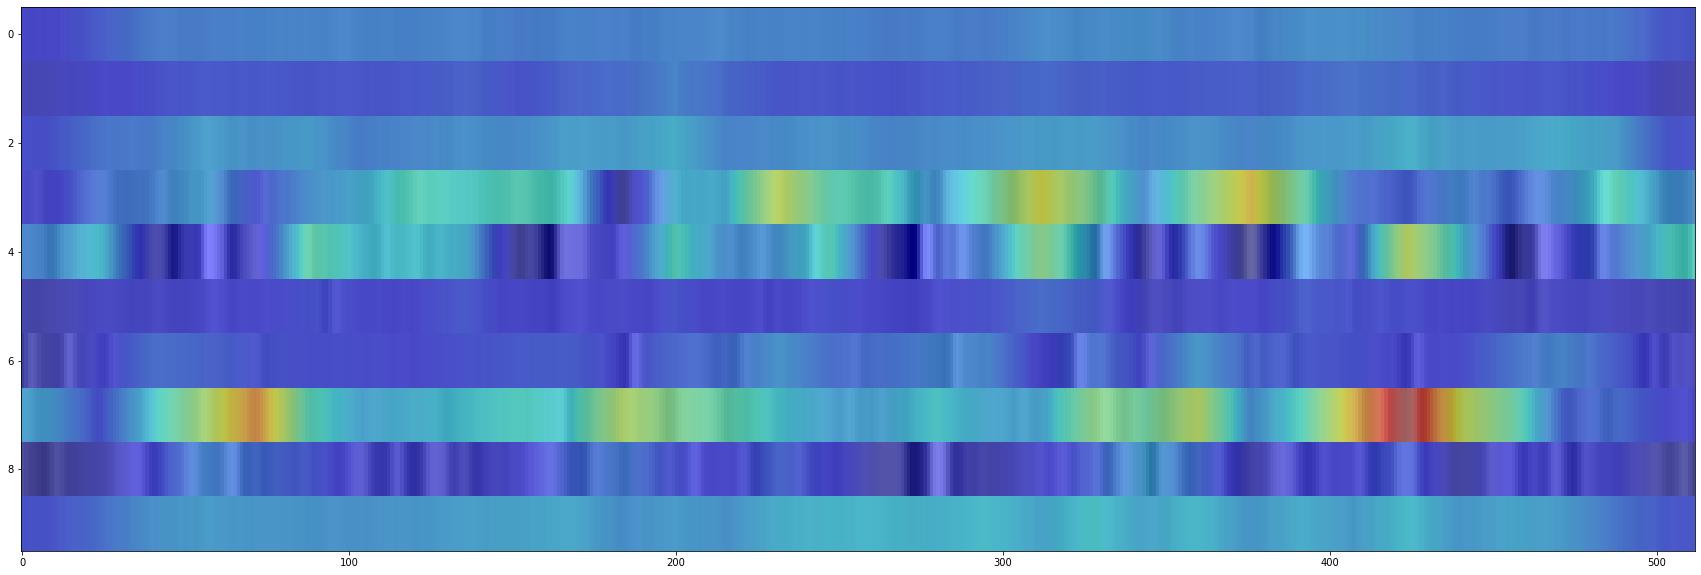

In [87]:
plt.figure(figsize=(30,10)) 
plt.imshow(x[0,:,:,0], interpolation='nearest', cmap='Greys')
plt.imshow(gradcam, cmap='jet', aspect='auto', alpha=0.5)
#plt.imshow(x[0,:,:,0], cmap='Greys')
plt.savefig('C:\\Users\\noemi\\Desktop\\university\\university\\tesi\\Thesis-XAI\\resources\\images\\gradcam_label5.jpg')

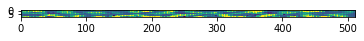

In [30]:
plt.imshow(np.flip(deprocess_image(gb[0,:,:,0]), -1))

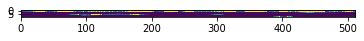

In [31]:
plt.imshow(np.flip(deprocess_image(guided_gradcam[0,:,:,0]), -1))

## SHAP

In [13]:
import requests
from skimage.segmentation import slic, felzenszwalb
import shap

In [14]:
# load model data
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()

In [15]:
img = image.load_img(image_path, target_size=(224, 224))
img_orig = image.img_to_array(img)
preds=model.predict(preprocess_input(np.expand_dims(img_orig, axis=0)))
print(decode_predictions(preds,10))

NameError: name 'image_path' is not defined

(10, 512)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
[[ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 ...
 [ 0  0  0 ... 63 63 63]
 [ 0  0  0 ... 63 63 63]
 [ 0  0  0 ... 63 63 63]]


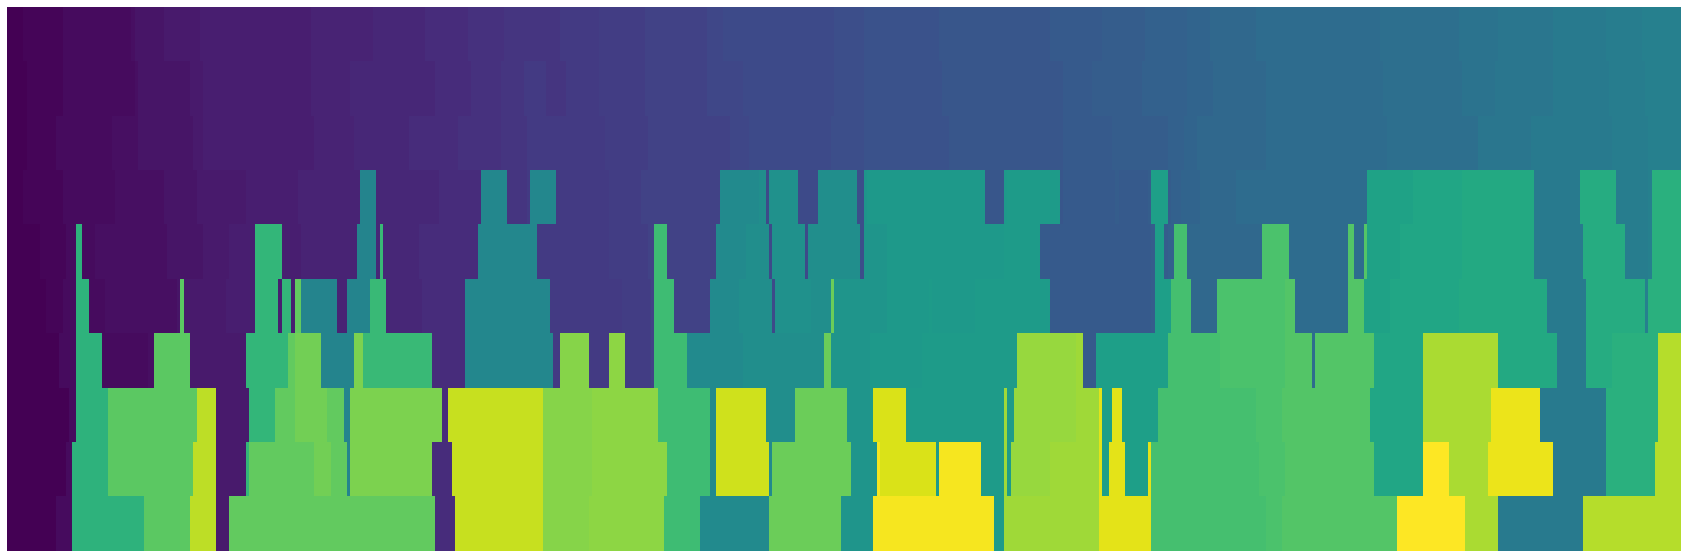

In [16]:
segments_slic = felzenszwalb(Xtest[0,:,:,0], scale=0.0001, sigma=0.6)
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic))
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');

In [17]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return saved_modelt.predict((mask_image(z, segments_slic, Xtest[0,:,:,:], 255)))

In [18]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,71)))
shap_values = explainer.shap_values(np.ones((1,71)), nsamples=1000) # runs VGG16 1000 times

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [19]:
print(len(shap_values))
shap_values[0].shape
# get the top predictions from the model
#preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
#print(decode_predictions(preds))
top_preds = np.argsort(-preds)
np.argmax(preds[0])

8


7

In [20]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [21]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
inds = top_preds[0]
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])

[[0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]
 [0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]
 [0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]
 ...
 [0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]
 [0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]
 [0.03106097 0.03106097 0.03106097 ... 0.         0.         0.        ]]


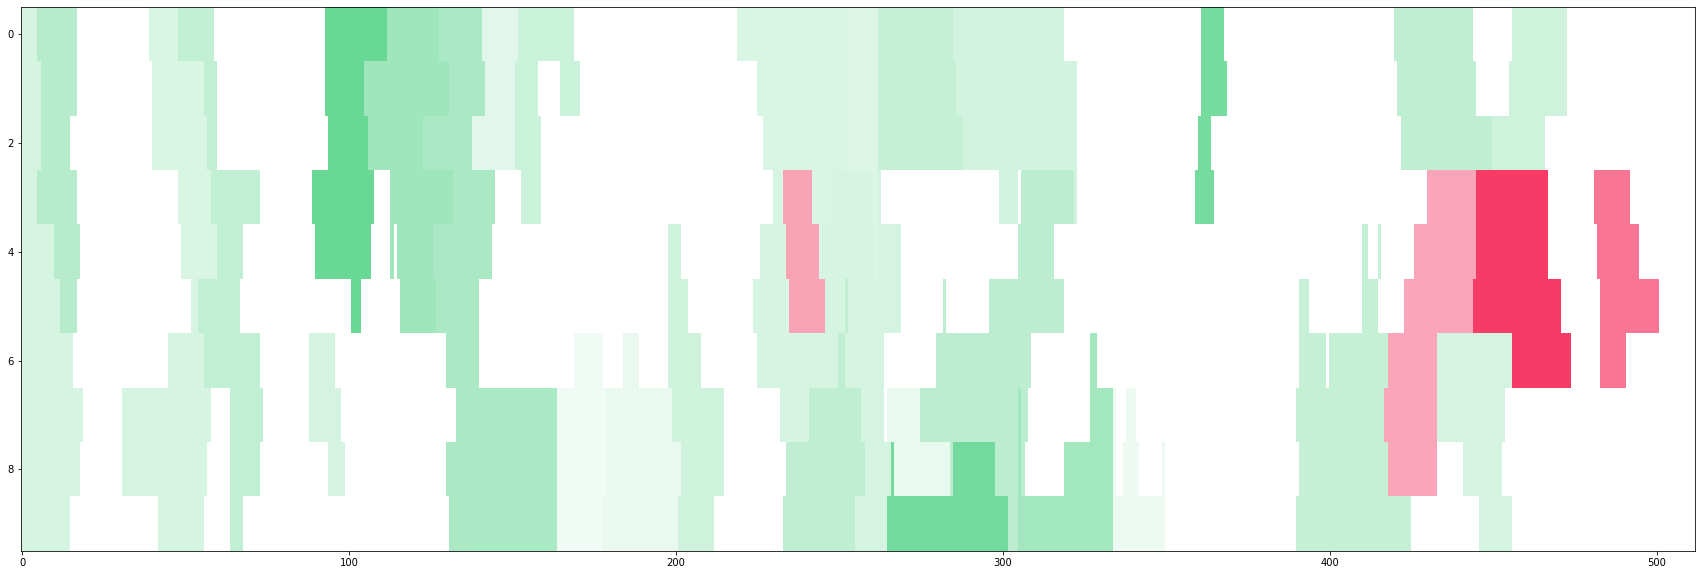

In [22]:
#best result
m = fill_segmentation(shap_values[inds[0]][0], segments_slic)
print(m)
plt.figure(figsize=(30,10))
plt.imshow(m, cmap=cm, vmin=-max_val, vmax=max_val, aspect="auto")

0.0839865312713709

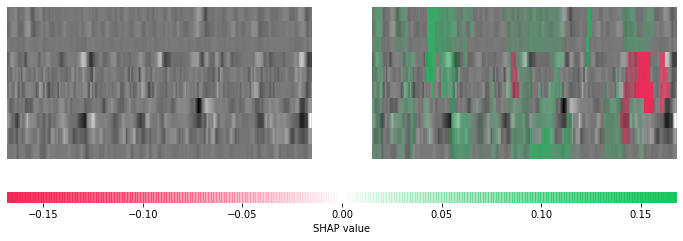

<Figure size 2160x720 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
# plot our explanations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
plt.figure(figsize=(30,10))
axes[0].imshow(Xtest[0,:,:,0], cmap='gray',aspect="auto")
axes[0].axis('off')
for i in range(1):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    #axes[i+1].set_title(feature_names[str(inds[i])][1])

    axes[i+1].imshow(Xtest[0,:,:,0], cmap='gray',aspect="auto")
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val, aspect="auto")
    
    axes[i+1].axis('off', aspect="auto")
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()
plt.savefig("./shap_image.jpg")

## SEGMENTATION

(10, 512)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]
[[ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]
 [ 0  0  0 ... 18 18 18]
 ...
 [19 19 19 ... 46 46 46]
 [57 57 57 ... 46 46 46]
 [57 57 57 ... 46 46 46]]


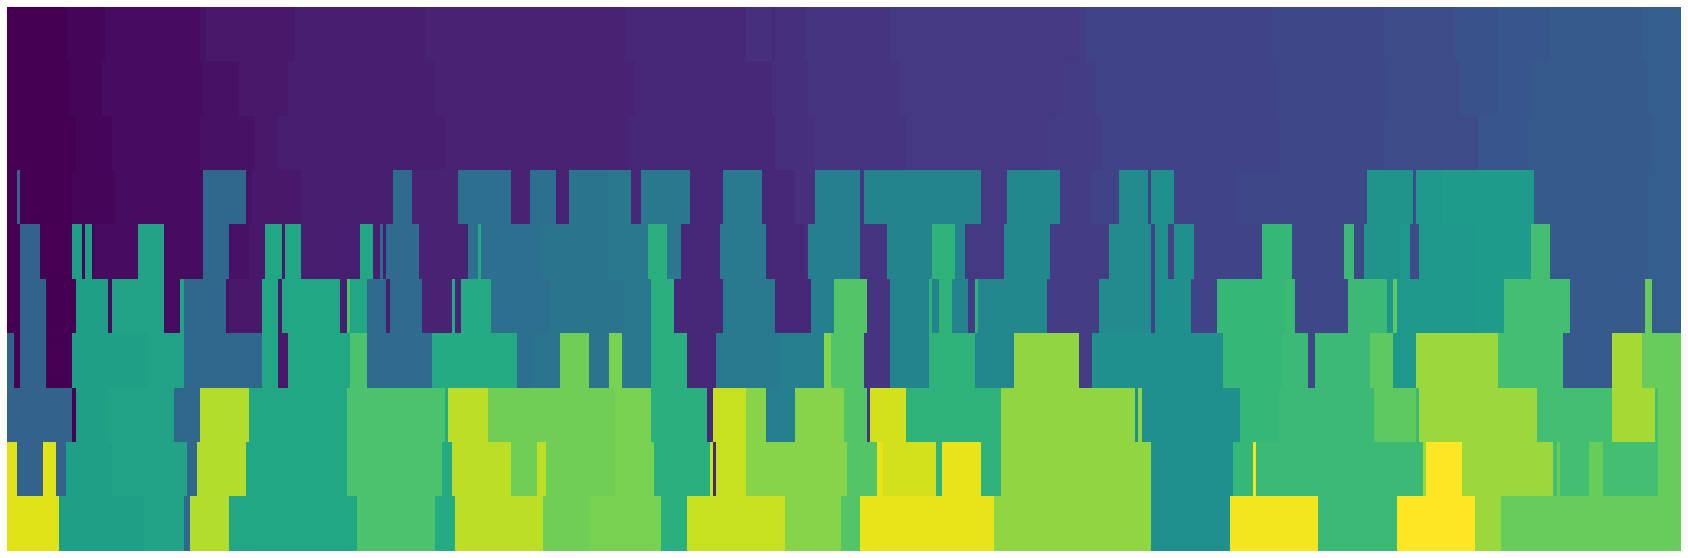

In [24]:
from skimage.segmentation import slic, felzenszwalb

segments_slic = felzenszwalb(Xtest[0,:,:,0], scale=0.0001, sigma=0.2)
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic))
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');


(10, 512)
(266,)
[[ 37  37  37 ...  36  62  62]
 [ 37  37  37 ...  62  62  62]
 [ 79  79  79 ... 105 106 106]
 ...
 [237 208 208 ... 173 106 266]
 [237 208 208 ... 207 266 266]
 [237 237 208 ... 207 266 266]]


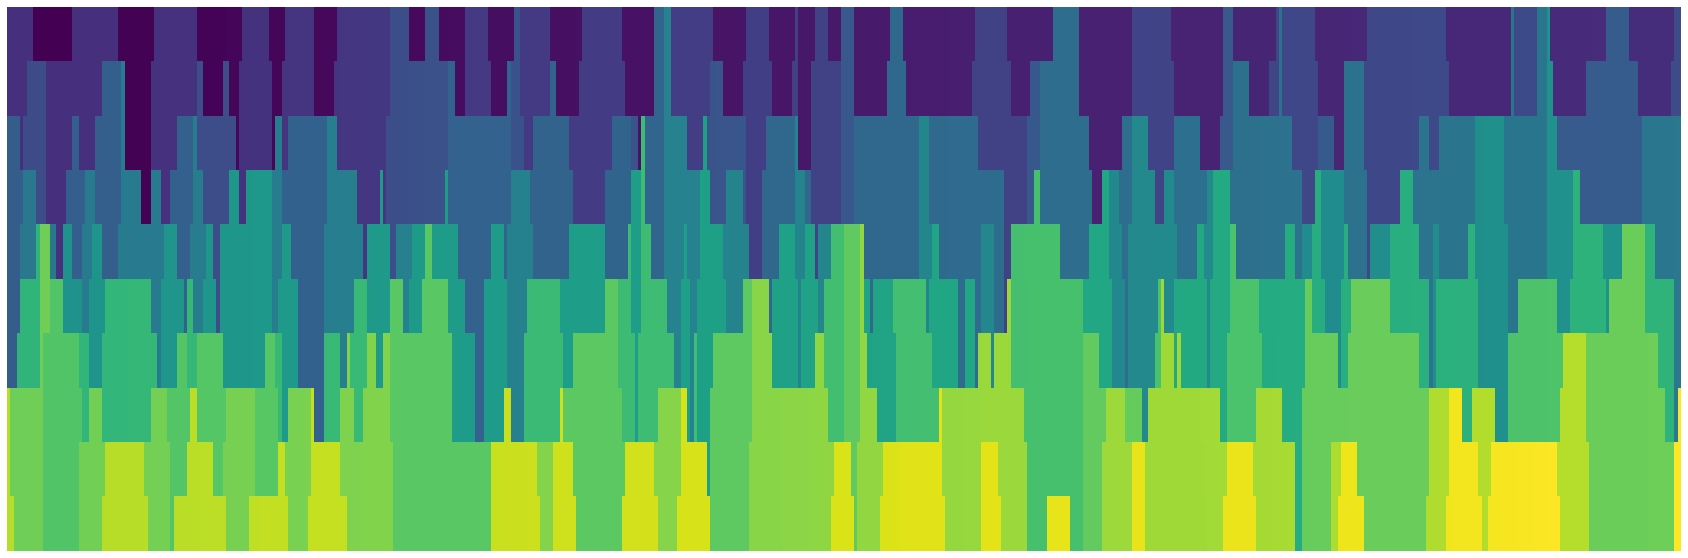

In [25]:
from skimage.segmentation import watershed
segments_slic=watershed(Xtest[0,:,:,0])
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic).shape)
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');

(10, 512)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
[[ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 ...
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]
 [ 0  0  0 ... 31 31 31]]


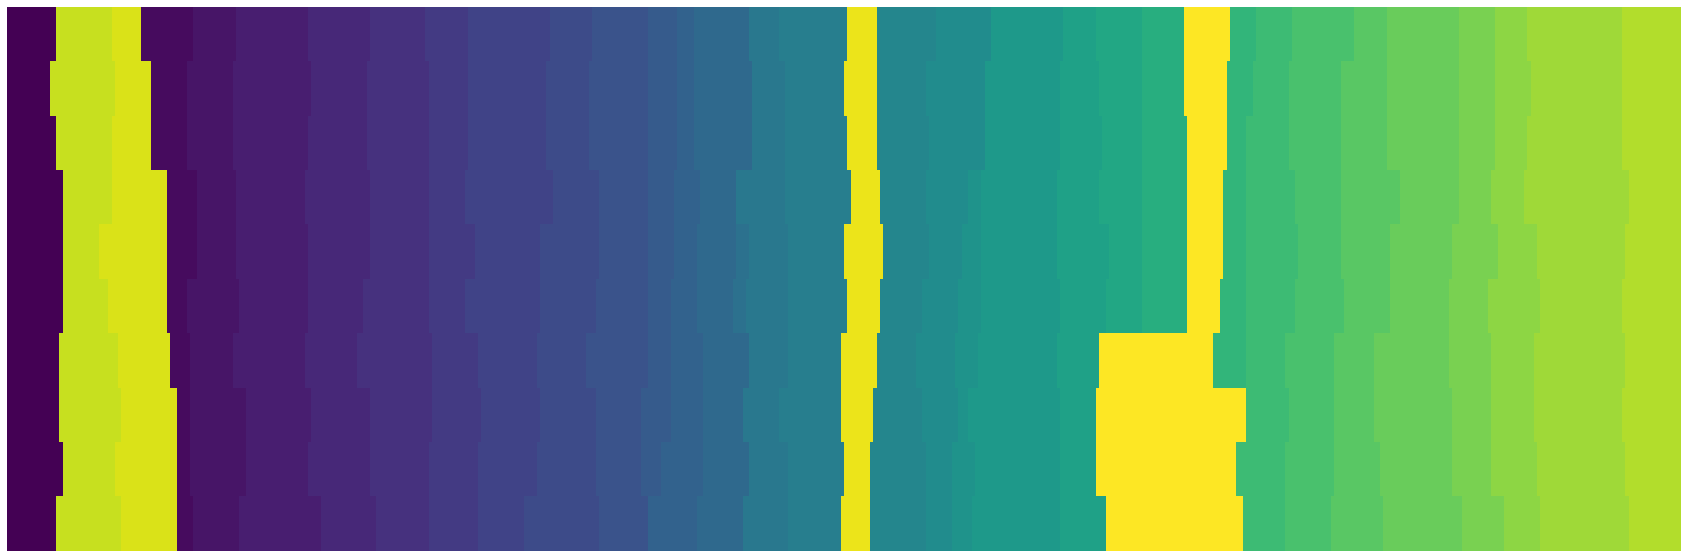

In [26]:
from skimage.segmentation import quickshift
segments_slic=quickshift(Xtest[0,:,:,0], ratio=0.2, kernel_size=2, max_dist=5, sigma=0, convert2lab=False)
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic))
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');

(10, 512)
(5120,)
[[0.88290777 0.86375201 0.84868066 ... 0.81106387 0.82316971 0.82353234]
 [0.88128545 0.86014712 0.84418231 ... 0.80120553 0.81424139 0.81981999]
 [0.89481733 0.86502271 0.84685013 ... 0.85911398 0.9044288  0.94427079]
 ...
 [0.84668767 0.83321334 0.81502084 ... 0.70673529 0.75855597 0.78088108]
 [0.86785219 0.83725469 0.81065998 ... 0.74384846 0.75459437 0.74498645]
 [0.82301039 0.82840164 0.82793261 ... 0.63941368 0.63767729 0.63981147]]


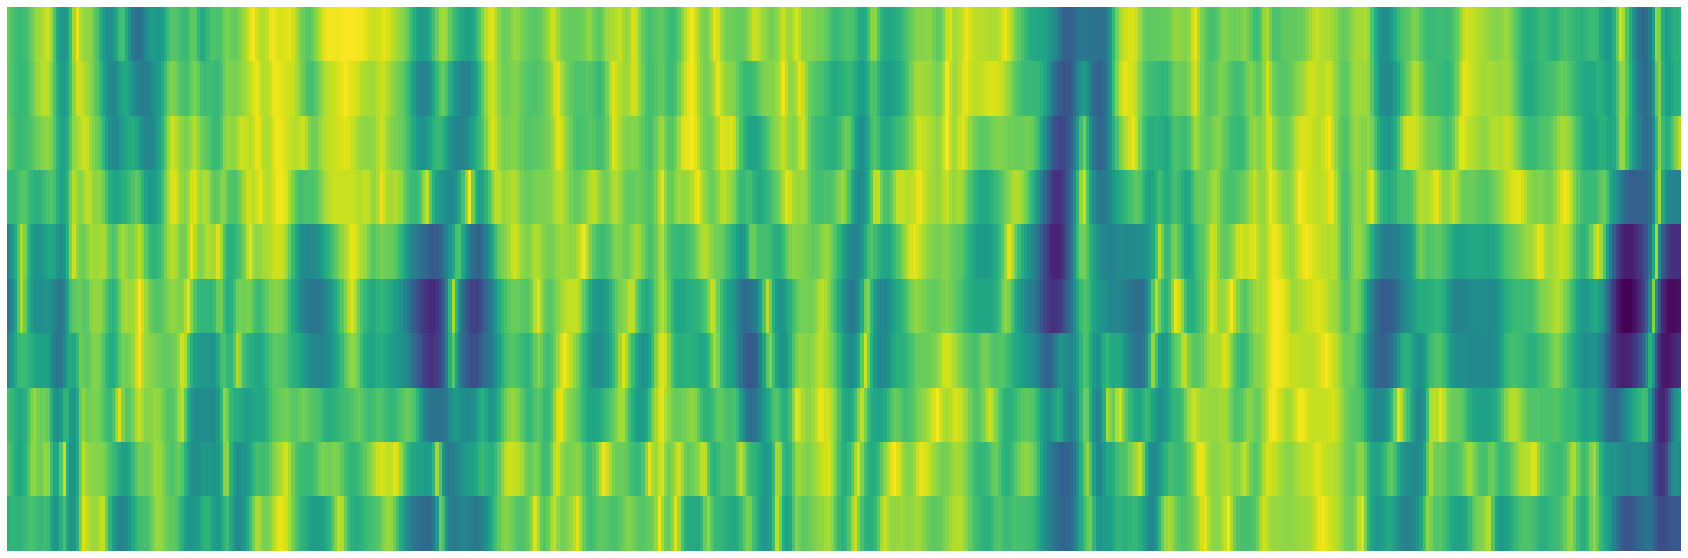

In [27]:
from skimage.segmentation import inverse_gaussian_gradient
segments_slic=inverse_gaussian_gradient(Xtest[0,:,:,0], alpha=50.0, sigma=2.0)
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic).shape)
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');

(10, 512)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
[[ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 50 50]
 ...
 [ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 50 50]
 [ 0  0  0 ... 50 50 50]]


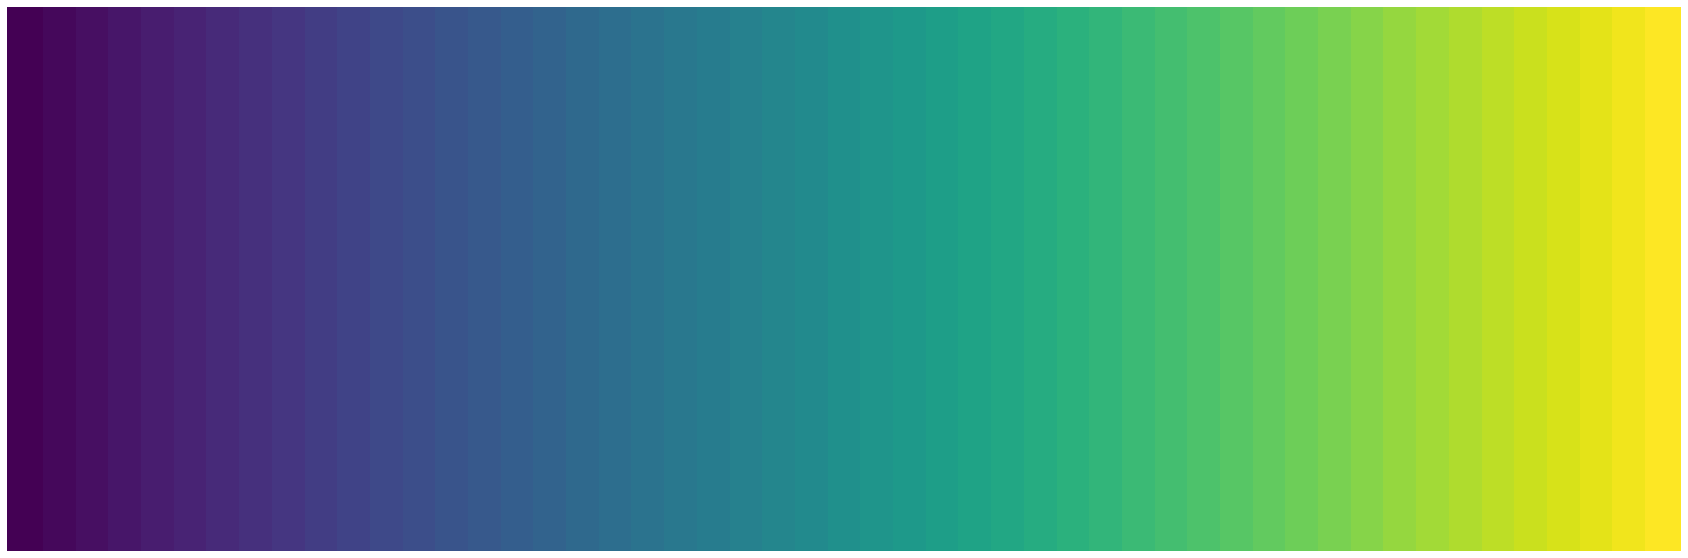

In [28]:
# segment the image so we don't have to explain every pixel
segments_slic = slic(Xtest[0,:,:,0], n_segments=50)
print(segments_slic.shape)
segments_slic
print(np.unique(segments_slic))
print(segments_slic)
plt.figure(figsize=(30,10)) 
plt.imshow(segments_slic, aspect="auto");
plt.axis('off');